## Post process analysis
- Load the turn by turn data
- Emittance evolution 
- Tune shift with amplitude

In [1]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import PyNAFF as pnf
sys.path.append('./utils')
from my_functions import *

### Plotting parameters

In [2]:
params = {'legend.fontsize': 16,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 18,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Study parameters

In [18]:
f_rev = 11.2455e3  # revolution frequency [Hz]
# Relativistic parameters
gamma_rel = 7460.52252807237 # from madx twiss
beta_rel = sqrt(1-(1/gamma_rel)**2)
# Twiss parameters
twiss = DottedDict()
twiss.beta_x = 115.75 #at IP3 #obtained from madx twiss. should be crossed check
twiss.beta_y = 1. 
twiss.alpha_x = 0 
twiss.alpha_y = 0 
twiss.gamma_x = (1+twiss.alpha_x**2)/twiss.beta_x
twiss.gamma_y = (1+twiss.alpha_y**2)/twiss.beta_y
ex_norm = 2.5e-6
ex_geom = ex_norm/(beta_rel*gamma_rel)
#ex_geom = 0.047#*1e-9 #for SCC
sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
print(sigma_x, sigma_px)
particles = 15000
turns = 1000
file_name = 'oct5852.61_noise1.0_feedback0.2_betax115.75_H_particles15000_turns1000_aperture3e-2'
save_flag = False
Delta = 1.0#*sigma_px
gain = 0.2#*sigma_px
A =  3 #p.168
ksi = 0.03#*sigma_px

0.00019694541882215593 1.7014723008393603e-06


In [19]:
df = pd.read_pickle('./turn_by_turn_data/{}.pkl'.format(file_name))
#df = pd.read_pickle('./turn_by_turn_data/{}.pkl'.format(file_name))

### Emittance evolution 

In [13]:
e_x = [] # list for the values of geometric emittance over turns
for turn in range(turns):
    e_x.append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))

./utils/my_functions.py:18: RuntimeWarning: Mean of empty slice
  return np.nanmean( (numb - np.nanmean(numb))**2 )
./utils/my_functions.py:22: RuntimeWarning: Mean of empty slice
  return np.nanmean( (numbx - np.nanmean(numbx)) * (numbpx - np.nanmean(numbpx)) )


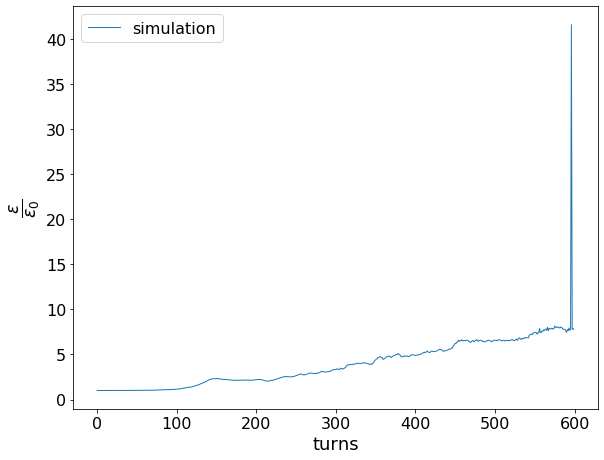

In [15]:
turns_list = np.arange(0,1000)
plt.plot(e_x/e_x[0], label = 'simulation')
#plt.plot(turns_list, 1+theory_rate*turns_list/e_x[0], label = r'$\frac{\Delta^2}{2}$')
plt.xlabel('turns')
plt.ylabel(r'$\frac{\epsilon}{\epsilon_0}$', fontsize = 25)
#plt.ylim(0.04, 0.05)
plt.tight_layout()
plt.legend()
save_flag = False
if save_flag:
    plt.savefig('./figures/emittance_{}.png'.format(file_name))

### Compare with theory prediction

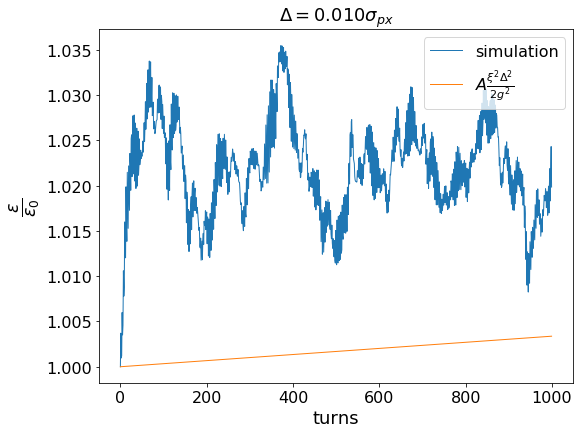

In [55]:
turns_list = np.arange(0,turns)
theory_rate = A*((ksi**2)*((Delta**2))/(2*gain**2))
plt.plot(e_x/e_x[0], label = 'simulation')
plt.plot(turns_list, 1 + theory_rate*turns_list, label = r'$A\frac{\xi^2 \Delta^2}{2g^2}$')
plt.xlabel('turns')
plt.ylabel(r'$\frac{\epsilon}{\epsilon_0}$', fontsize = 25)
plt.title(r'$\Delta={:.3f}$'.format(Delta)+ r'$\sigma_{px}$')
plt.legend()
#plt.savefig('./figures/{}.png'.format(file_name))

### Linear fit on the simulation data

In [57]:
turns_list = np.arange(0,1000)
[m_h,b_h], cov_h = np.polyfit(turns_list, e_x/e_x[0], 1, cov= True)

3.618759988154484e-15


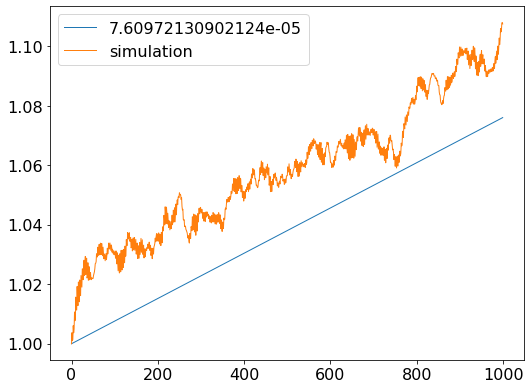

In [58]:
plt.plot(turns_list, m_h*turns_list+1, label = m_h)
plt.plot(e_x/e_x[0], label = 'simulation')
#plt.plot(turns_list, theory_rate*turns_list+ e_x[0], label = theory_rate)
print(Delta**2/2.)
plt.legend()

### Tune shift with amplitude
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns

In [38]:
x_data = {}
px_data = {}
y_data = {}
py_data = {}
for particle in range(particles):
    x_data[particle] = []
    px_data[particle] = []
    y_data[particle] = []
    py_data[particle] = []

In [39]:
for particle in range(particles):
    for turn in range(turns):
        x_data[particle].append(df.at[turn,'x'][particle])
        px_data[particle].append(df.at[turn,'px'][particle])
        y_data[particle].append(df.at[turn,'y'][particle])
        py_data[particle].append(df.at[turn,'py'][particle])

### Exclude the particles that are lost, otherwise NAFF crashes.

In [40]:
lost_particles = []
Qx_list = []
Qy_list = []

for particle in range(particles):
    if np.isnan(x_data[particle]).any() or np.isnan(px_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x = x_data[particle] # normalise by derivation with beta function
        signal_y = y_data[particle] # normalise by derivation with beta function
        Qx_list.append(pnf.naff(signal_x, turns, 1, 0, False)[0][1])
        #Qy_list.append(pnf.naff(signal_y, turns, 1, 0, False)[0][1])

### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate initial actions Jx
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [41]:
x_norm = df.at[0,'x']/sqrt(twiss.beta_x) # the index 0 corresponds to turn
px_norm = df.at[0,'px']*sqrt(twiss.beta_x)
Jx_initial = (x_norm**2 + px_norm**2)

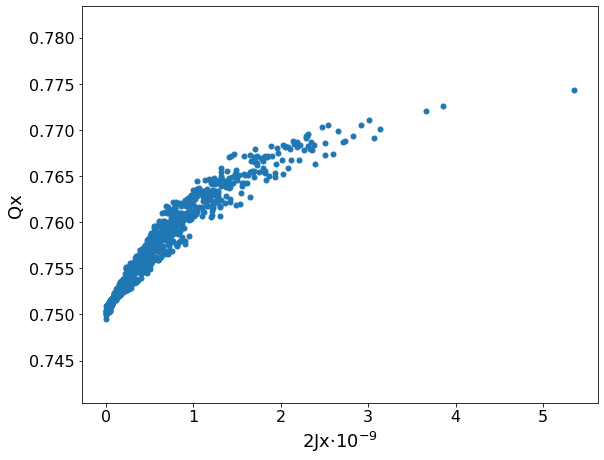

In [42]:
Qx_list_plot = [1-i for i in Qx_list]
plt.scatter(Jx_initial*1e9, Qx_list_plot) # the index 0 corresponds to turn
plt.xlabel('2Jx'+r'$\cdot 10^{-9}$')
plt.ylabel('Qx')
plt.tight_layout()
plt.savefig('./figures/tune_shift_{}.png'.format(file_name))

### Plot phase space - normalised

/home/natalia/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


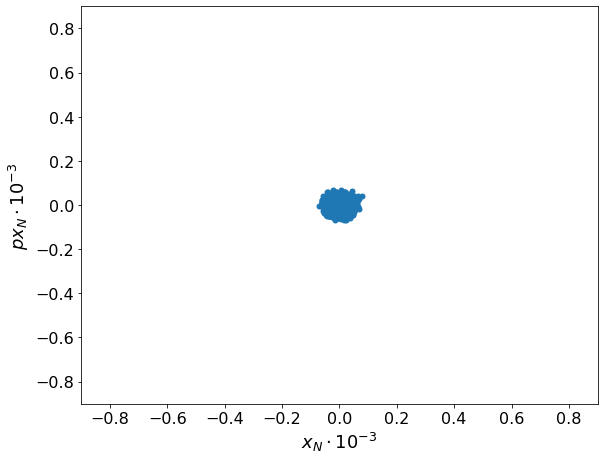

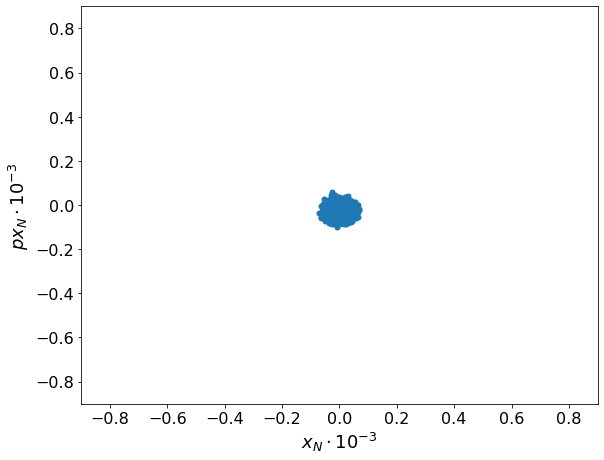

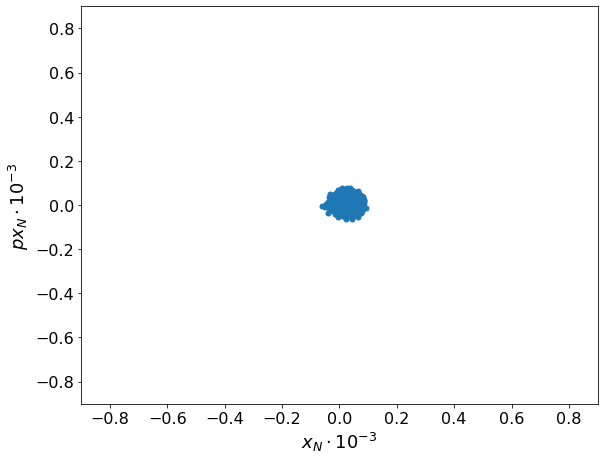

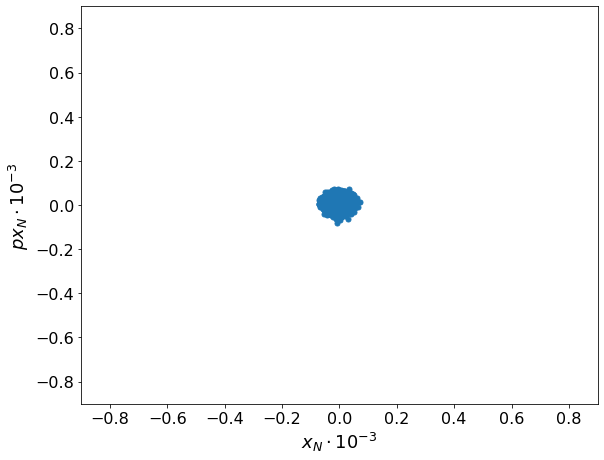

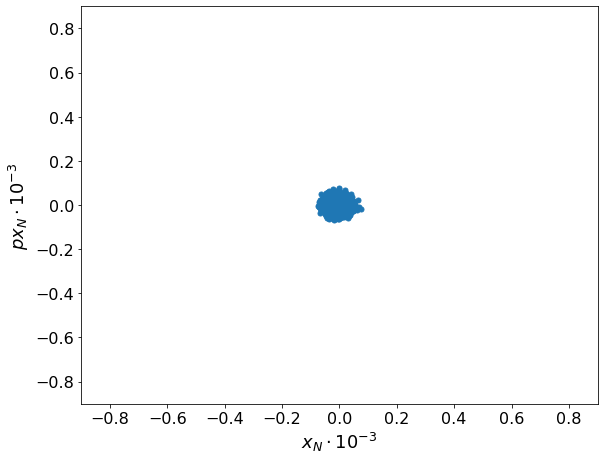

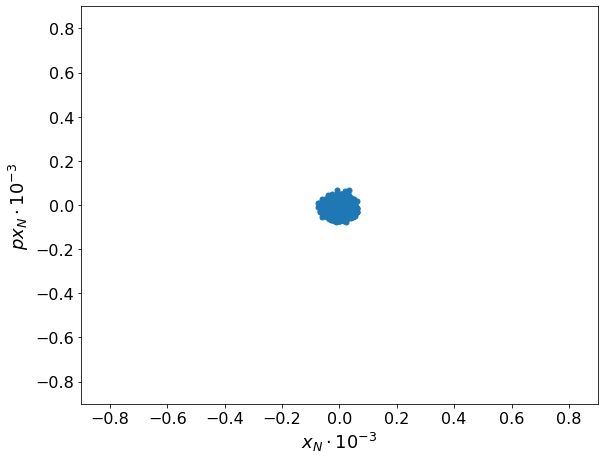

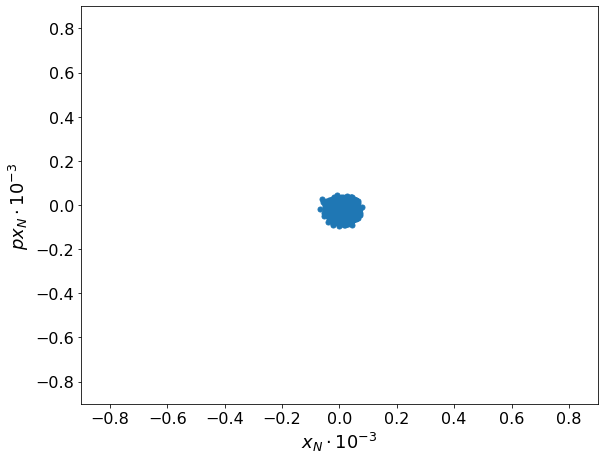

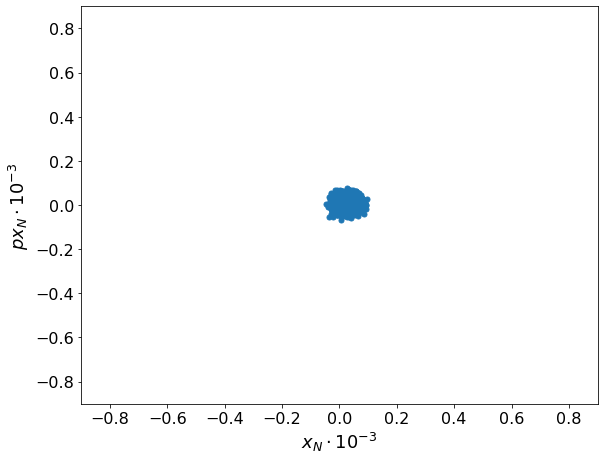

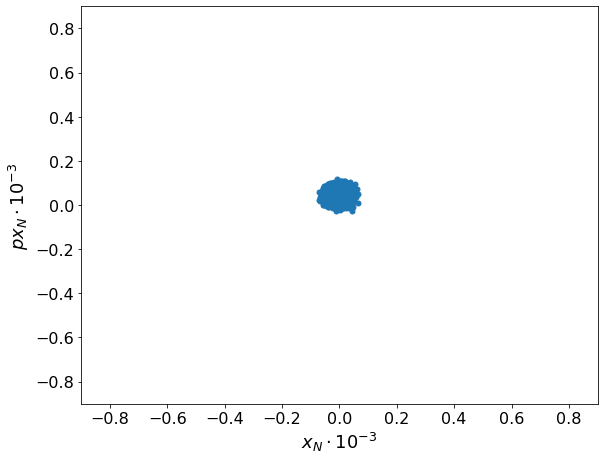

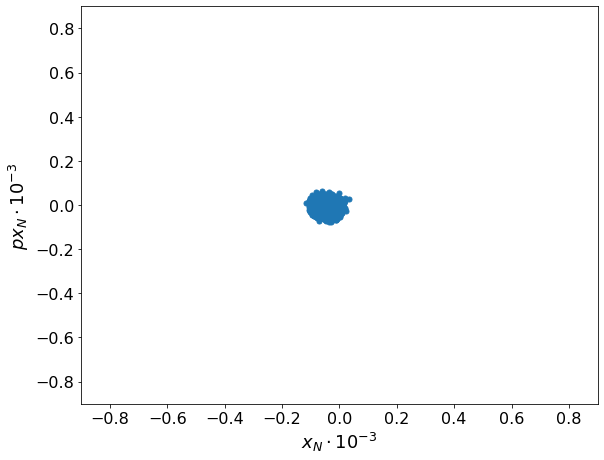

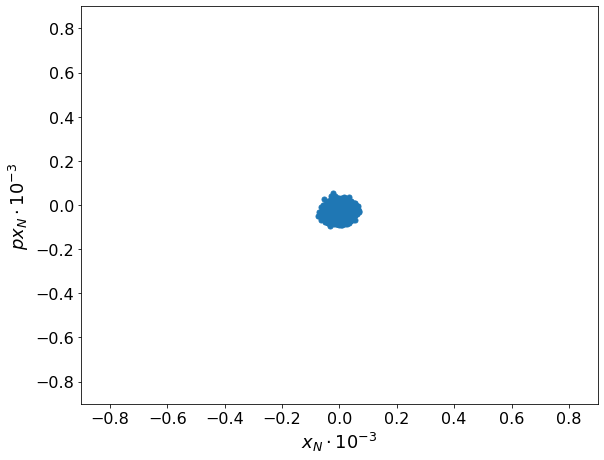

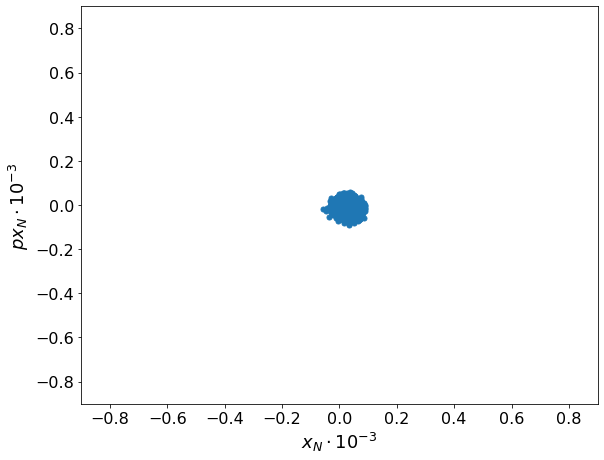

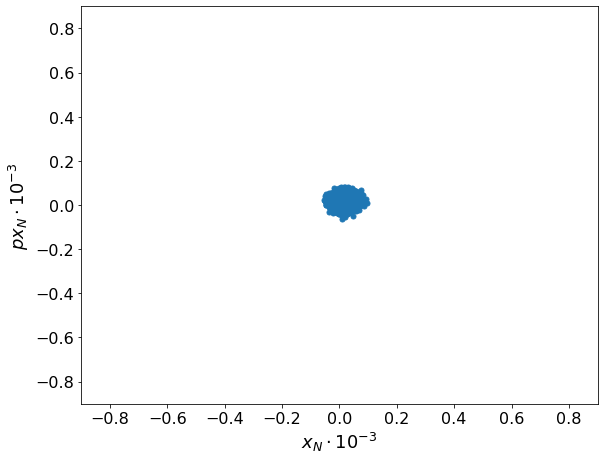

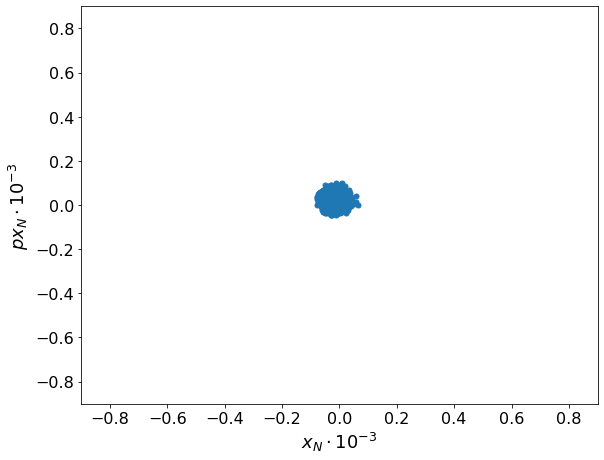

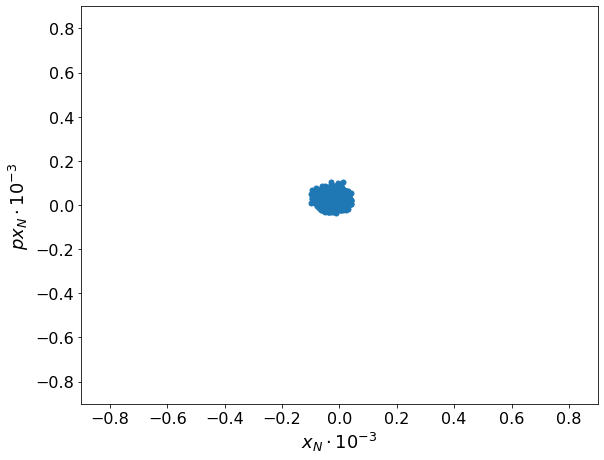

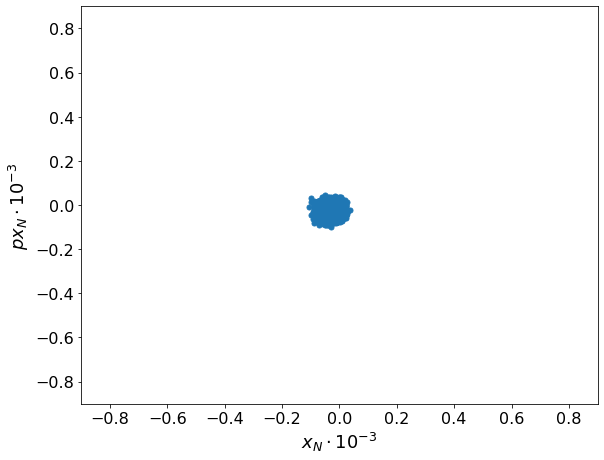

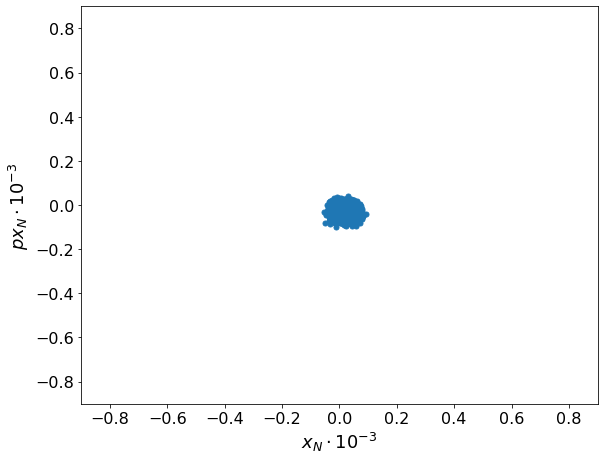

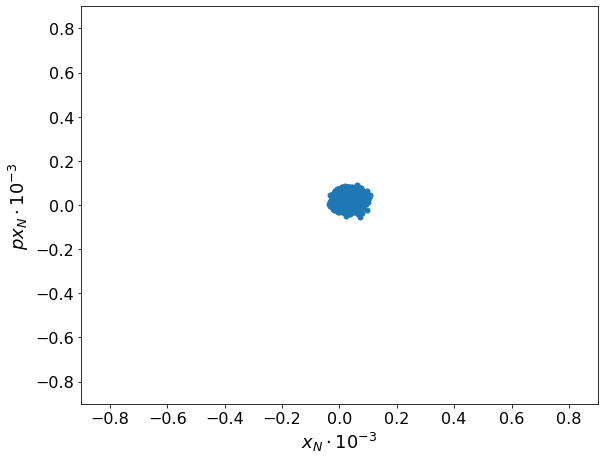

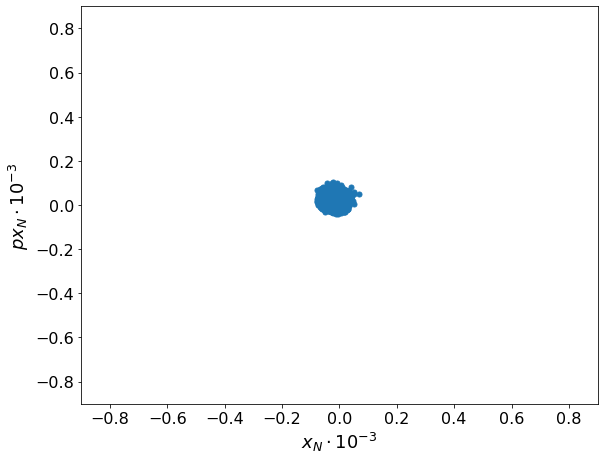

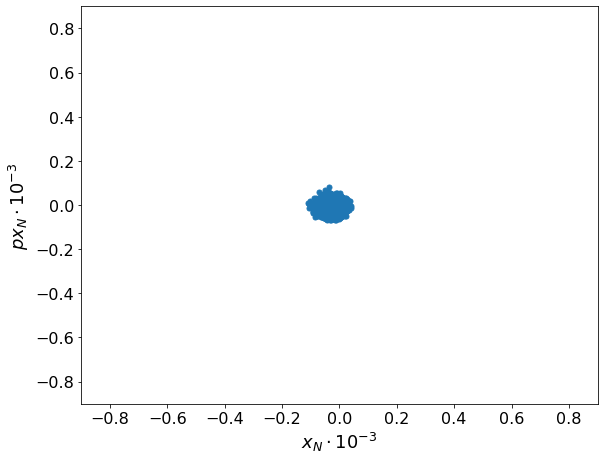

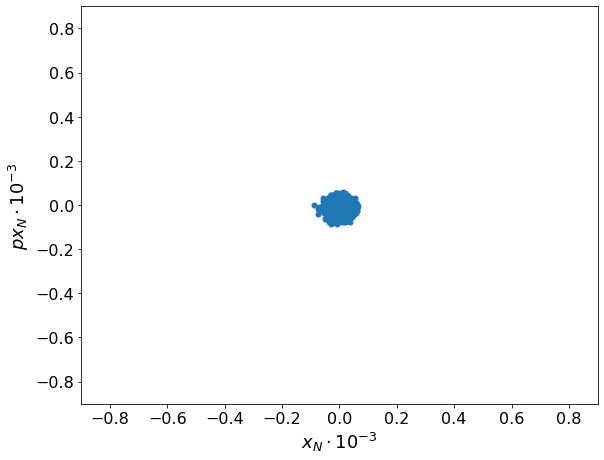

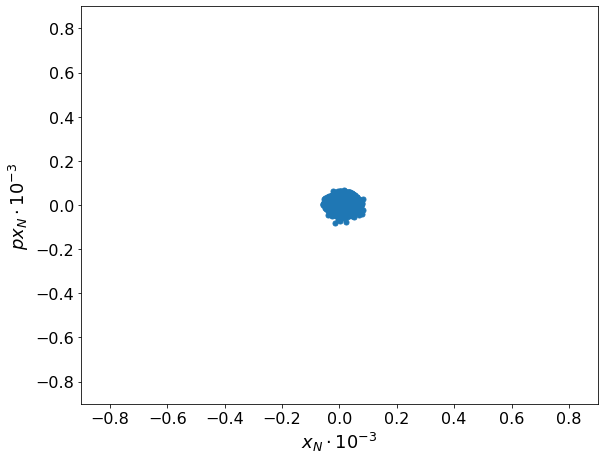

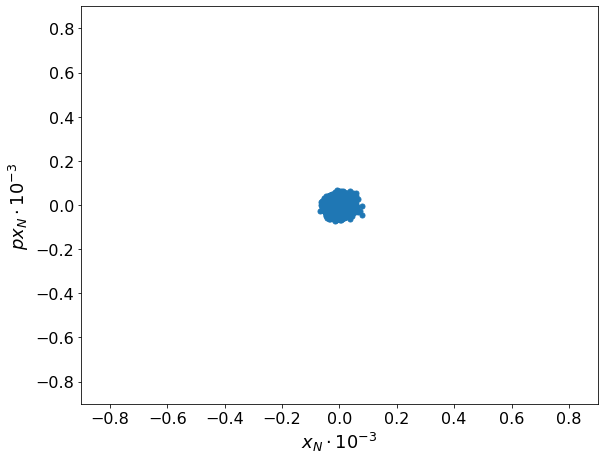

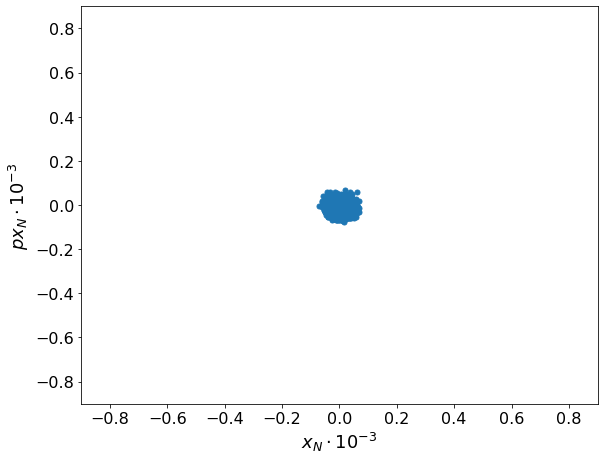

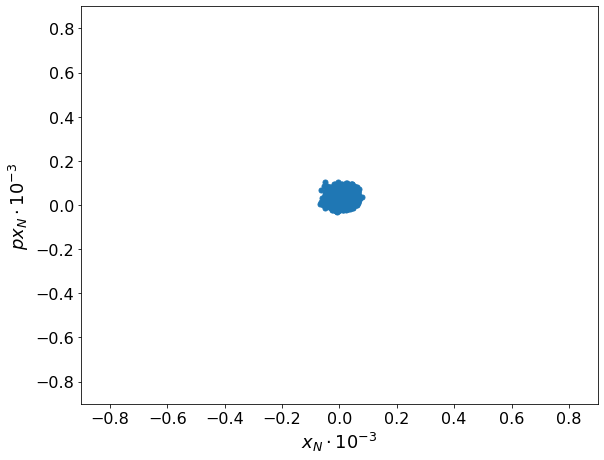

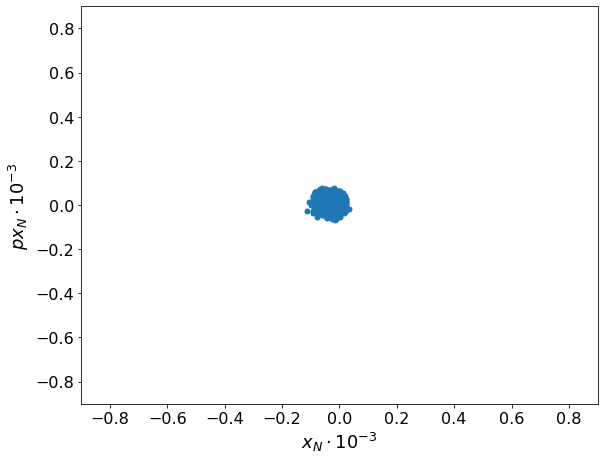

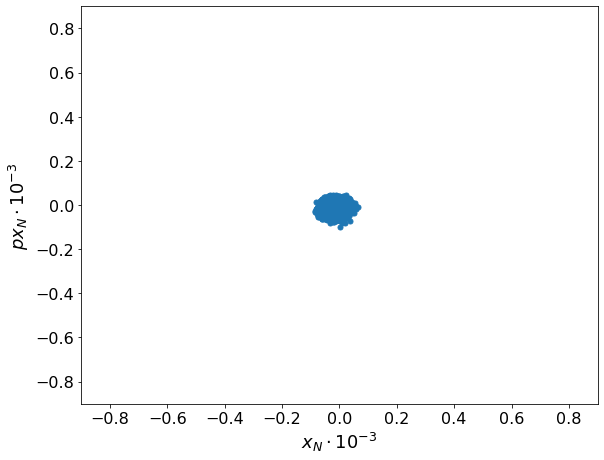

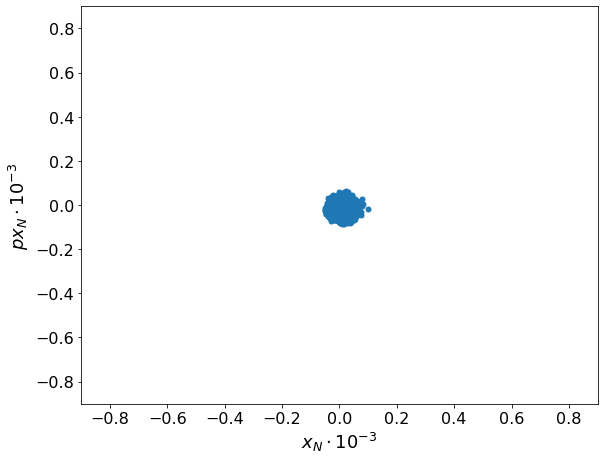

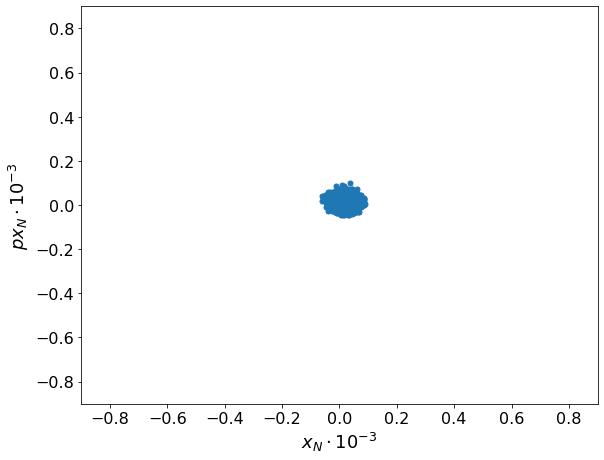

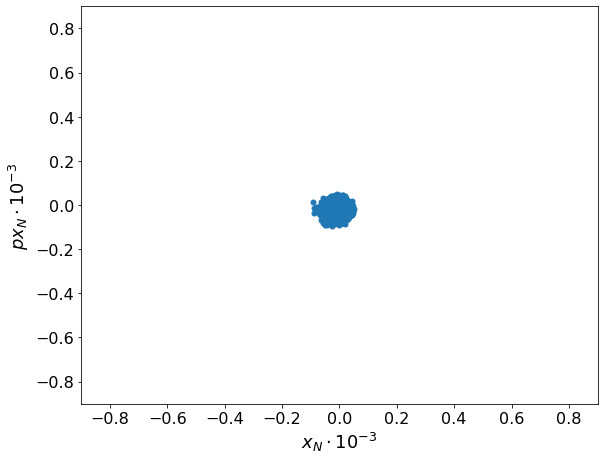

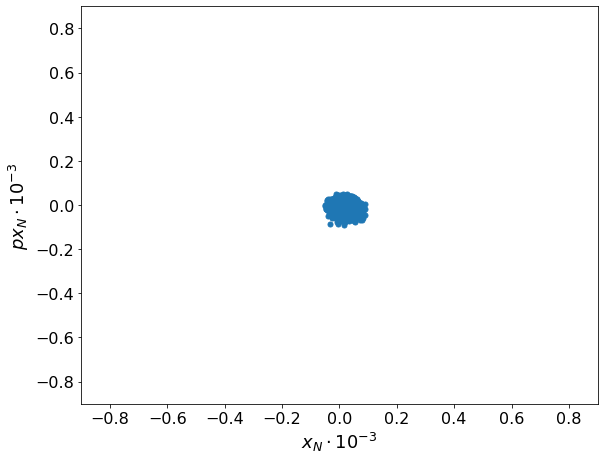

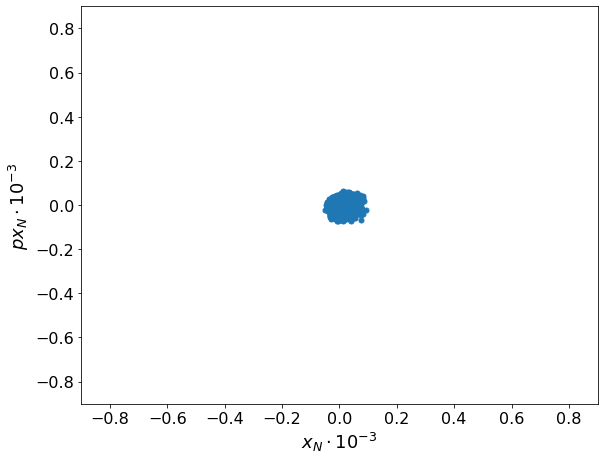

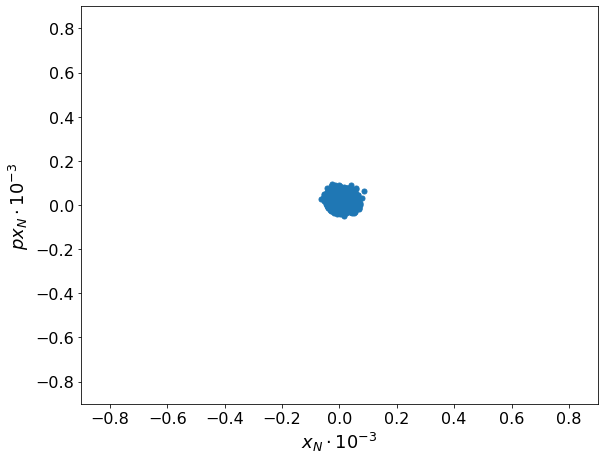

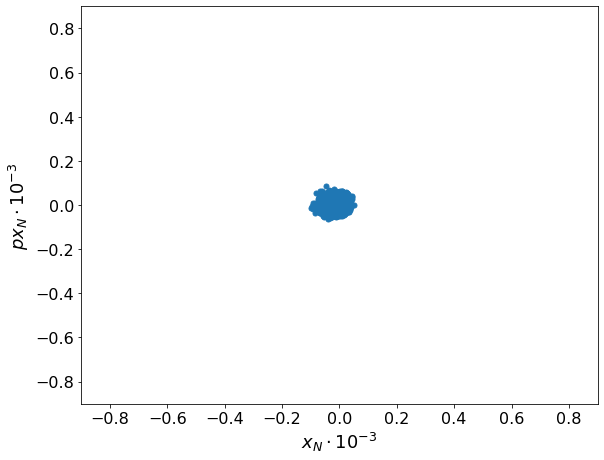

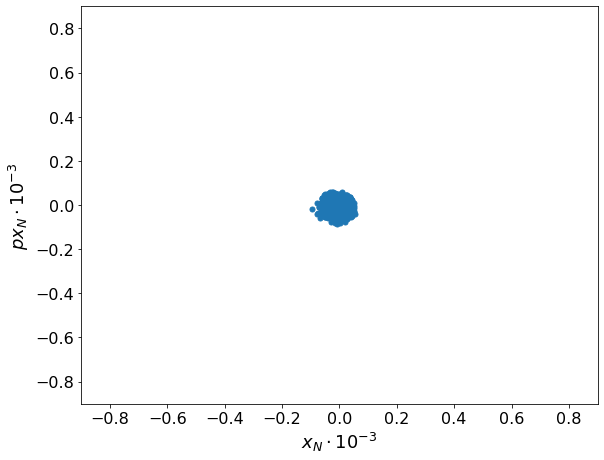

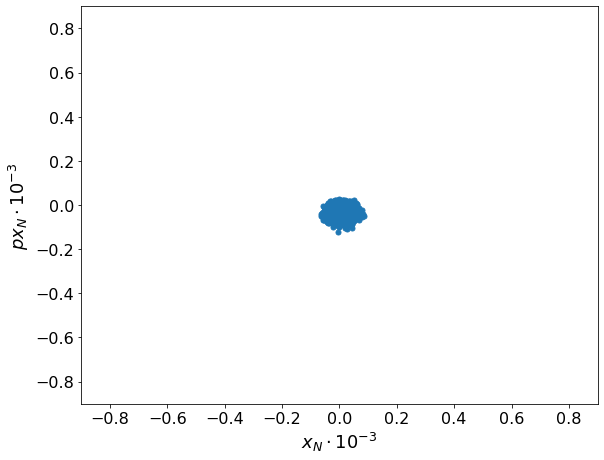

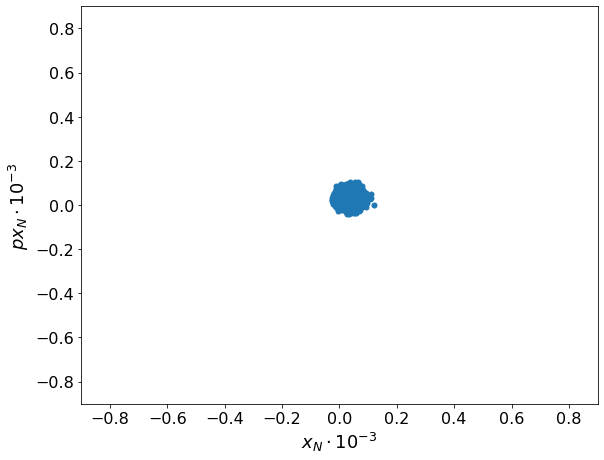

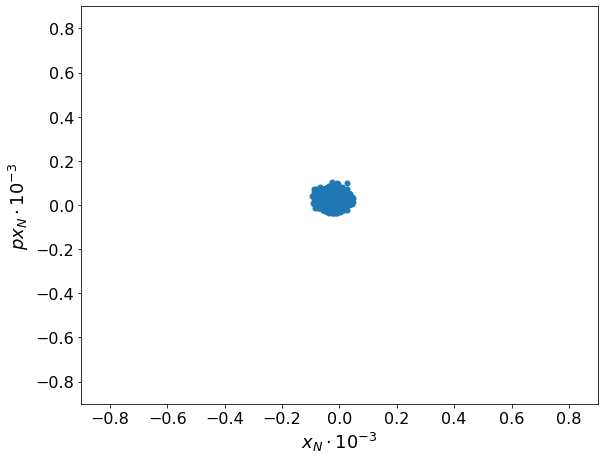

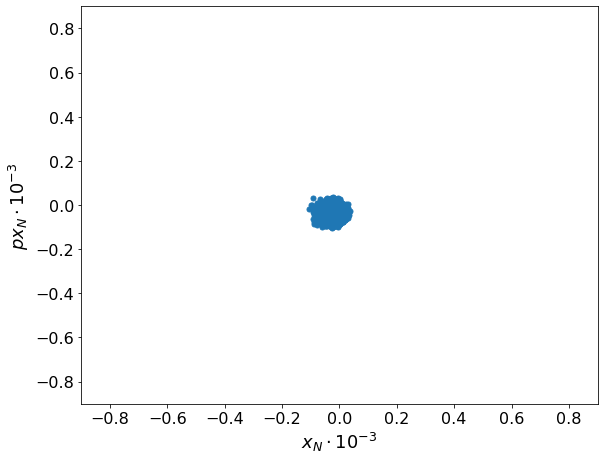

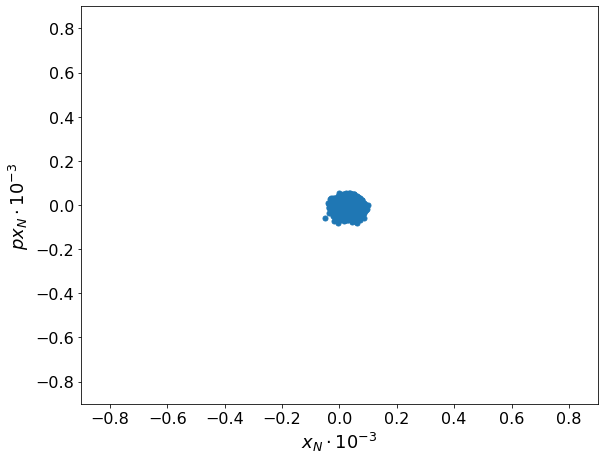

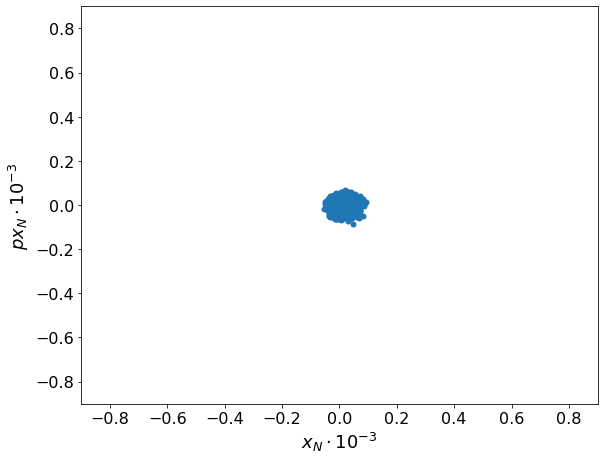

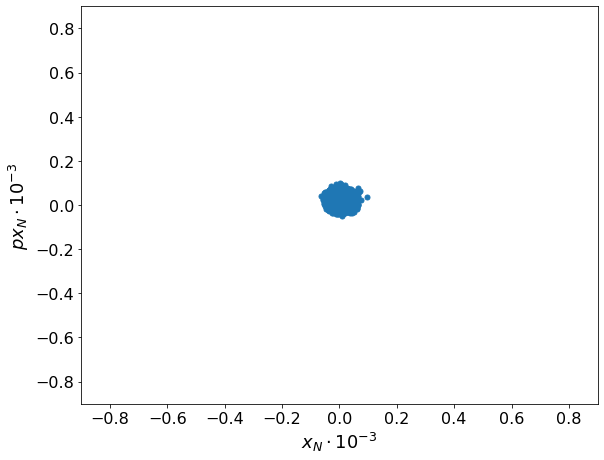

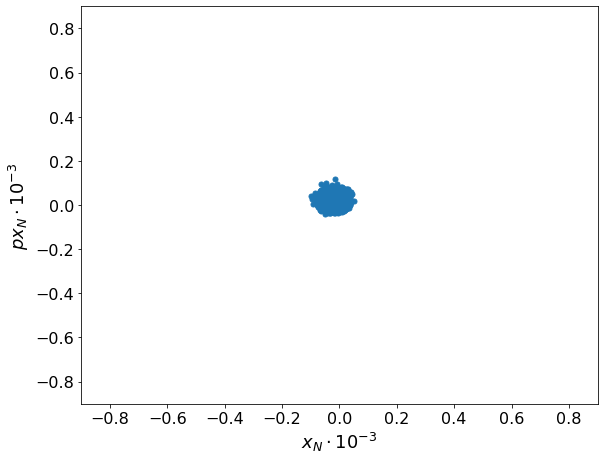

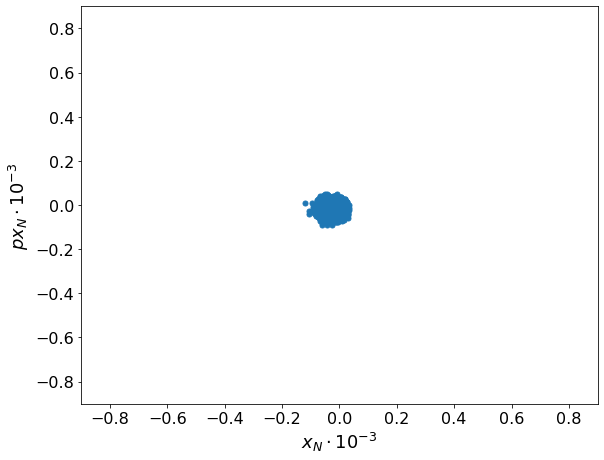

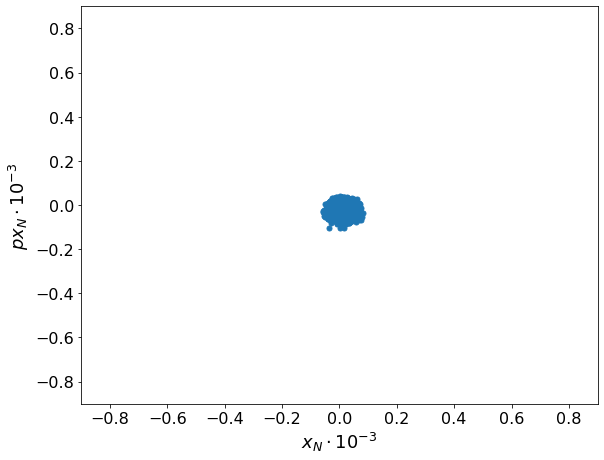

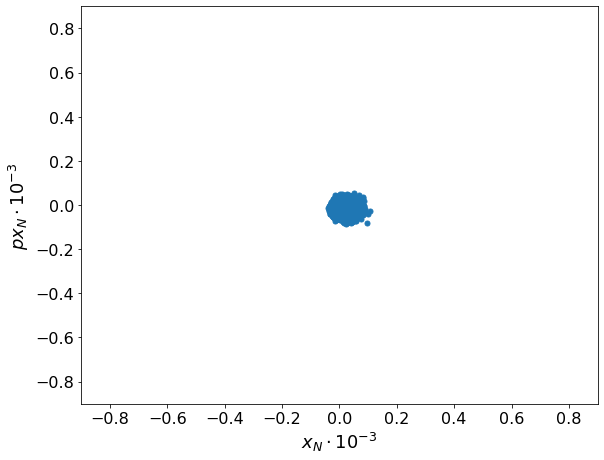

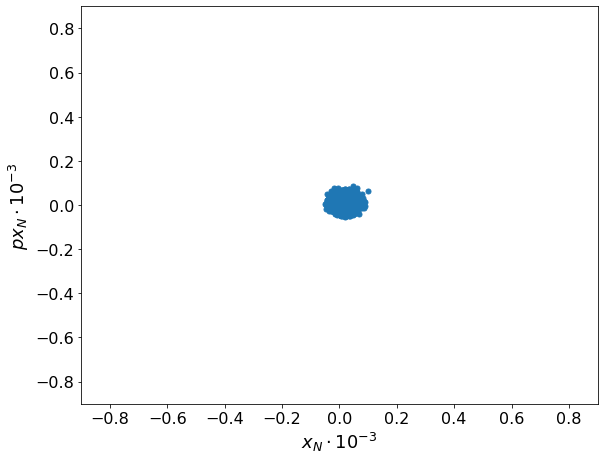

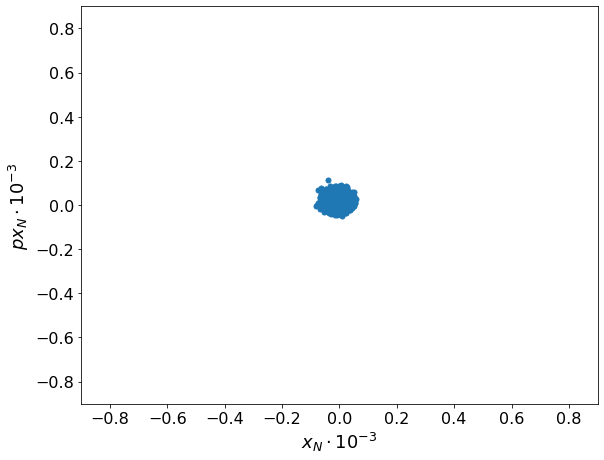

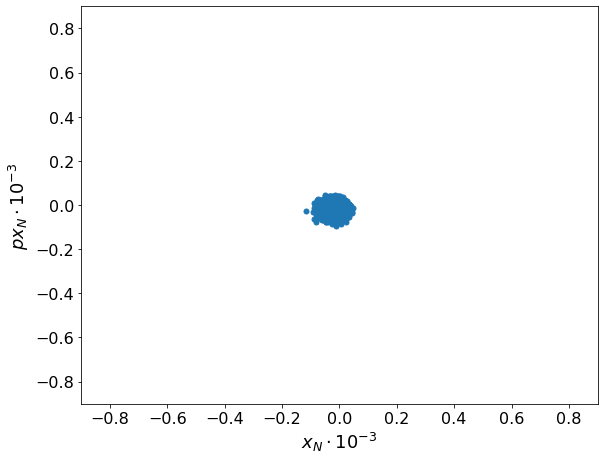

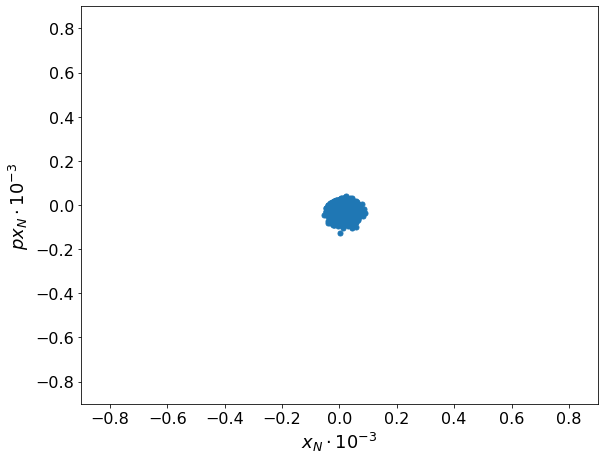

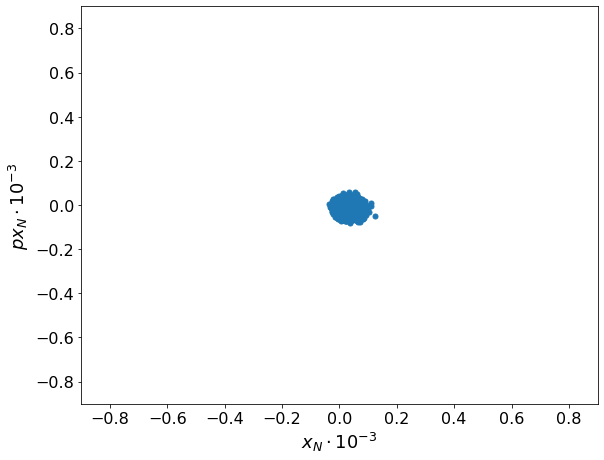

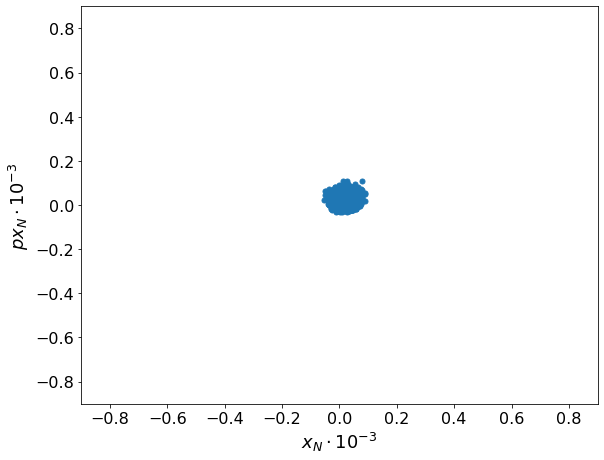

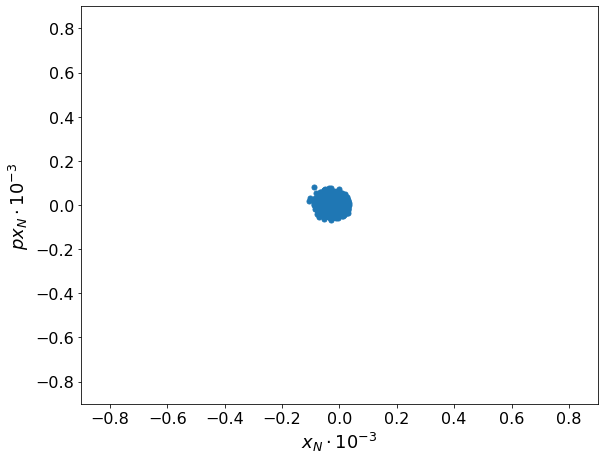

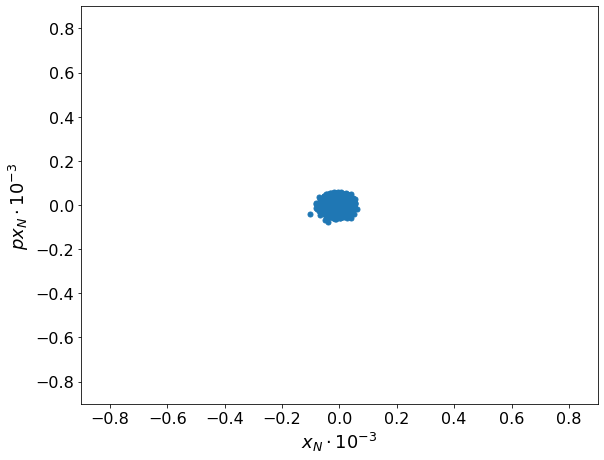

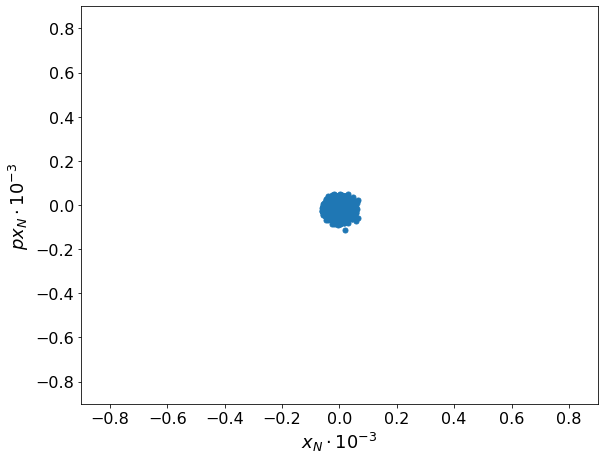

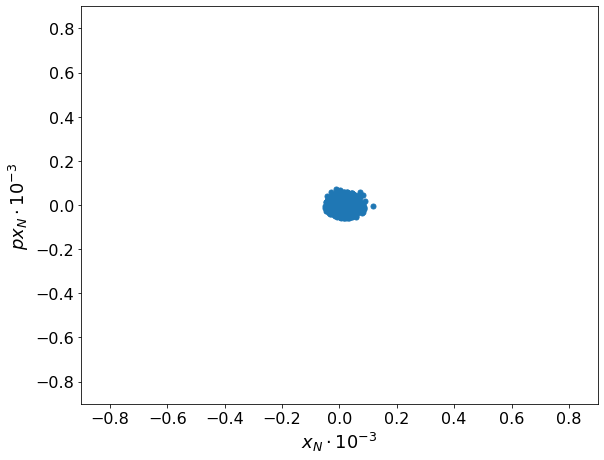

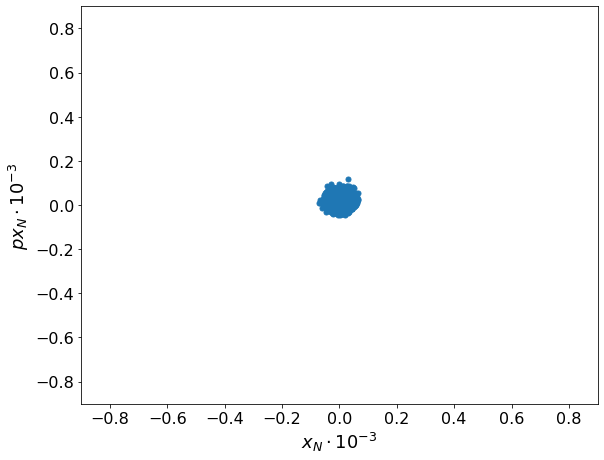

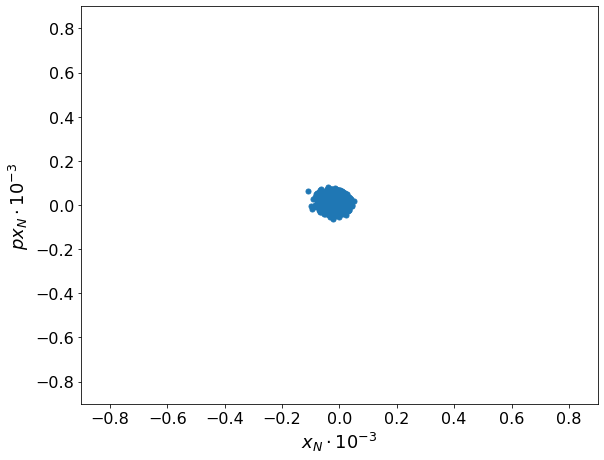

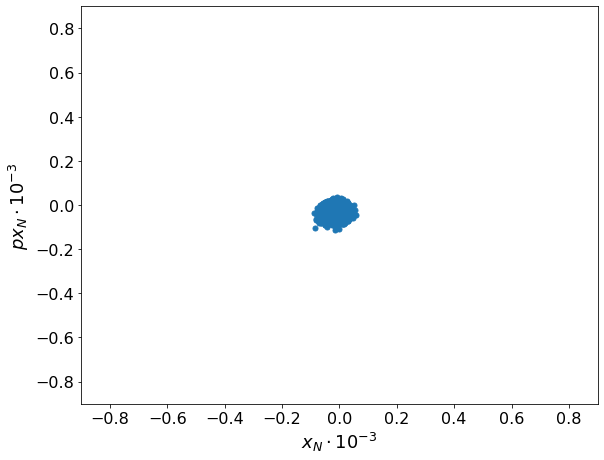

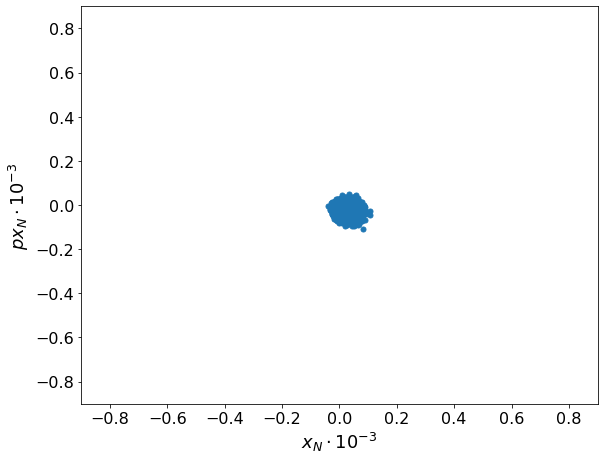

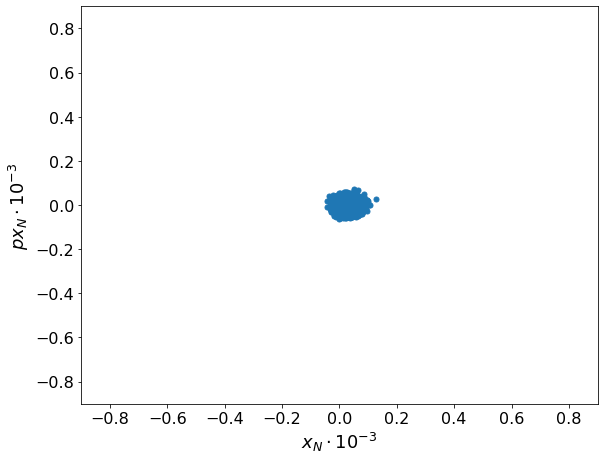

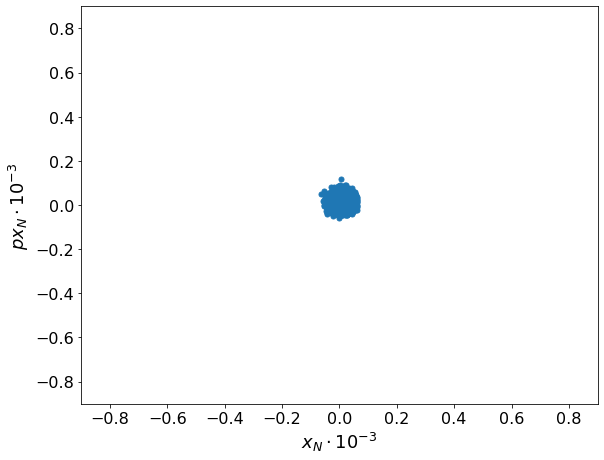

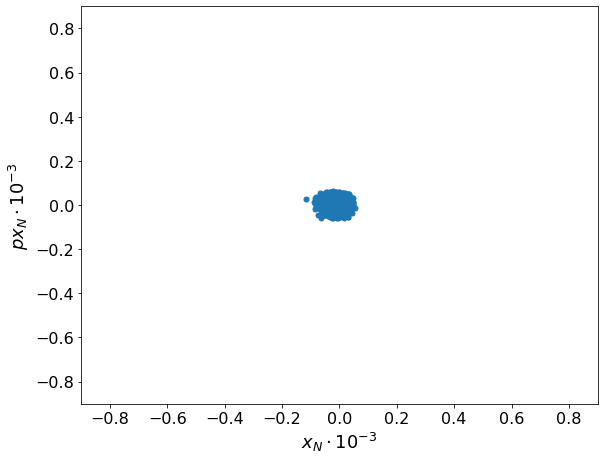

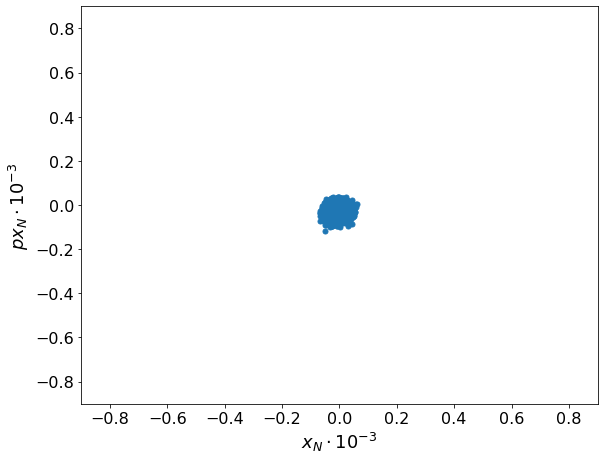

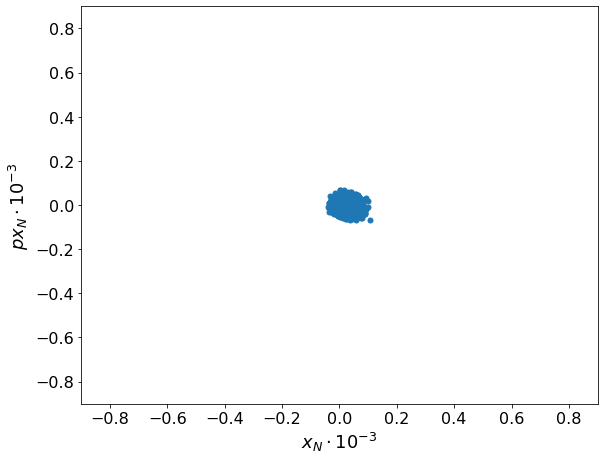

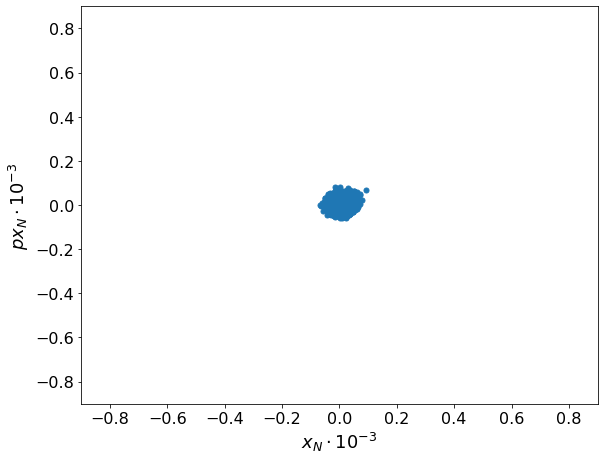

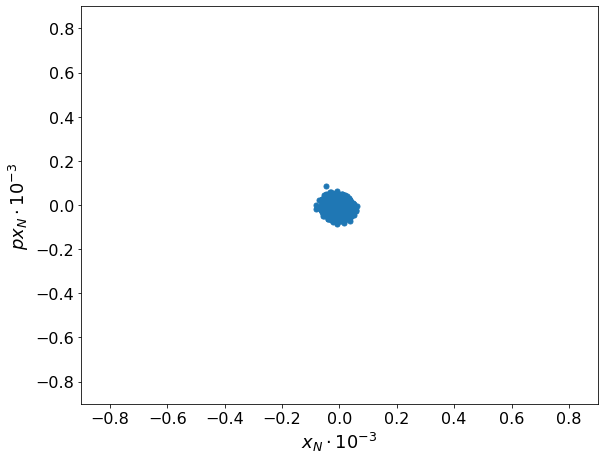

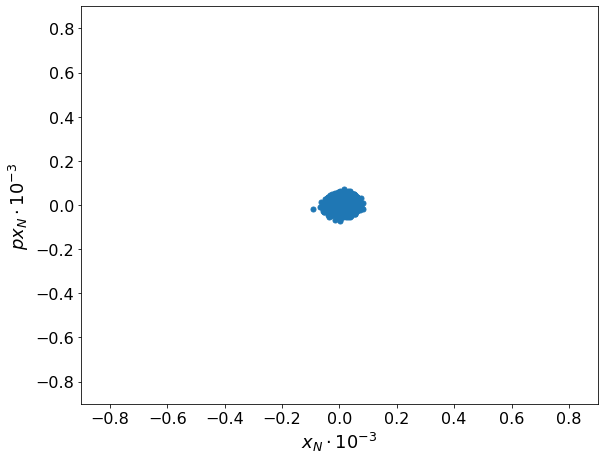

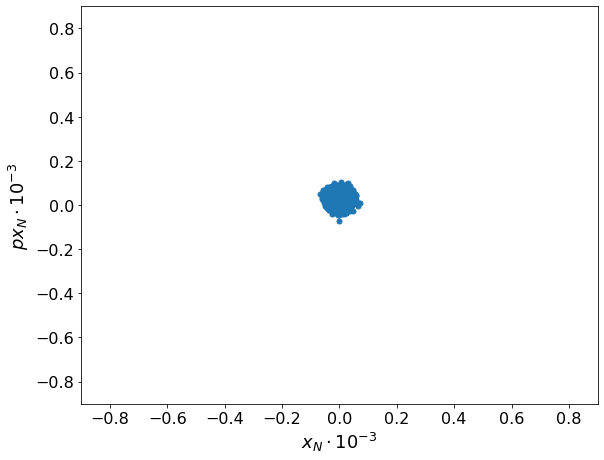

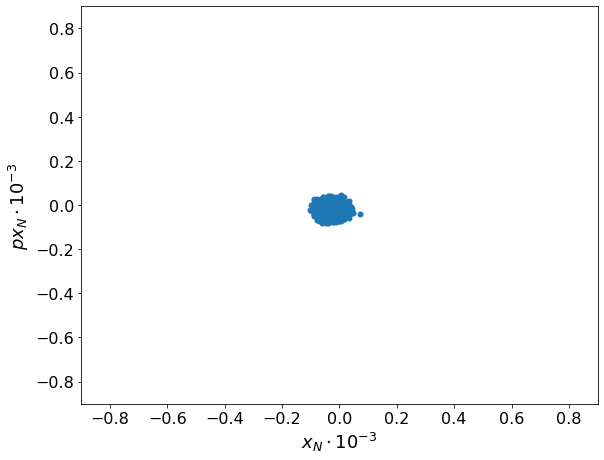

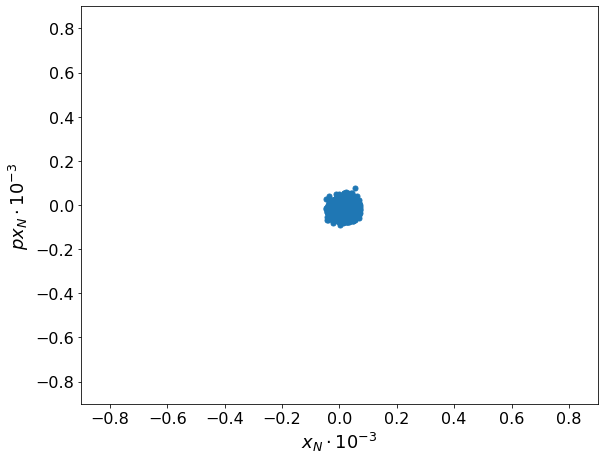

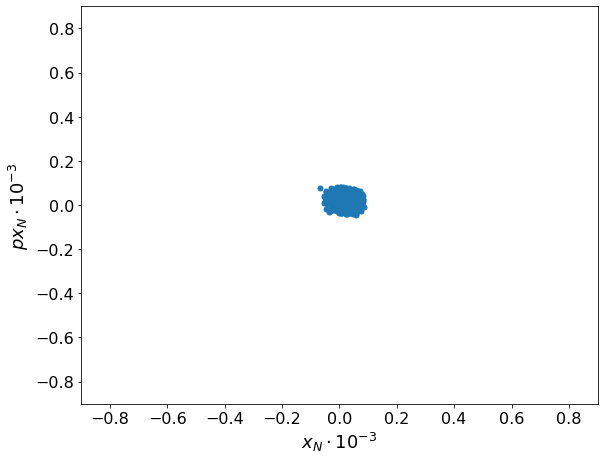

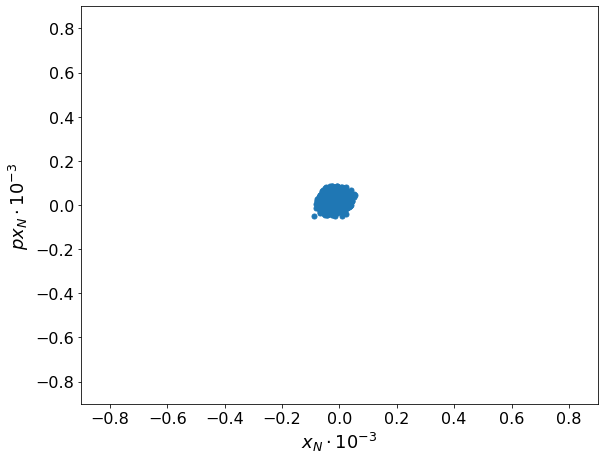

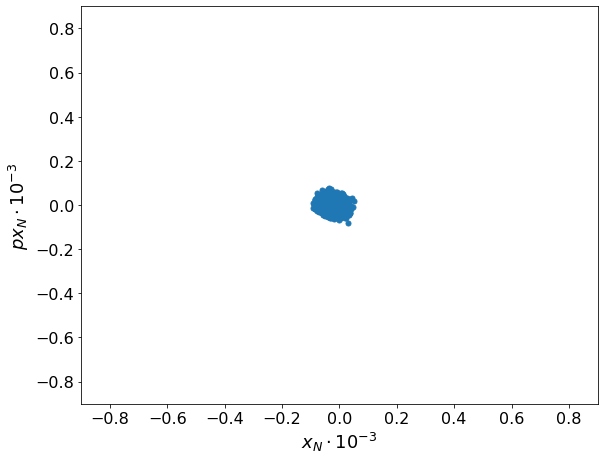

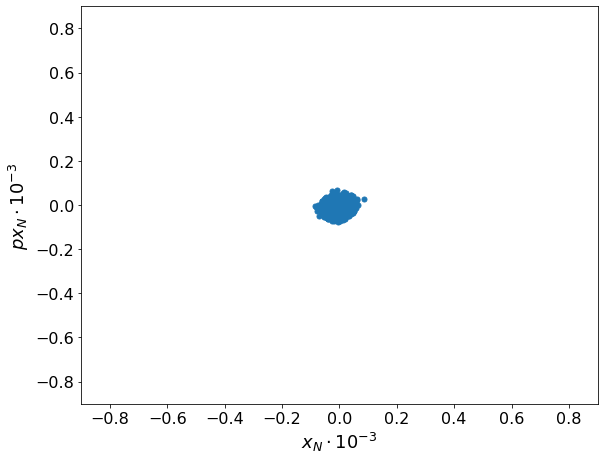

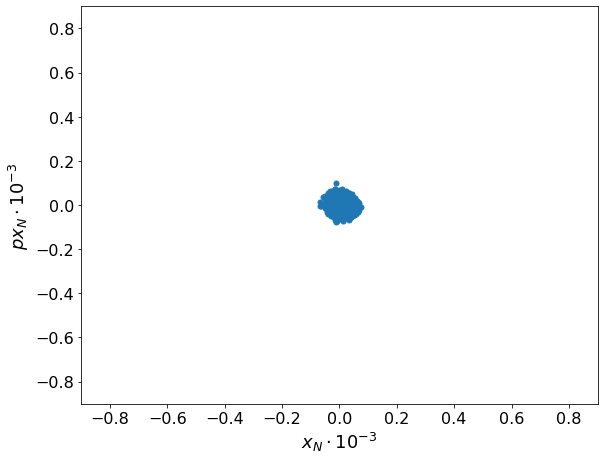

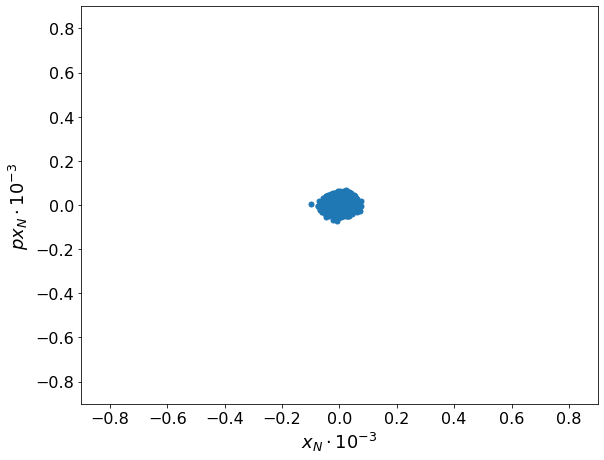

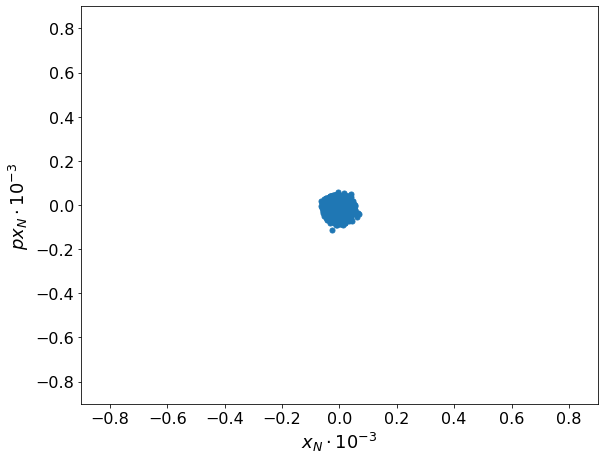

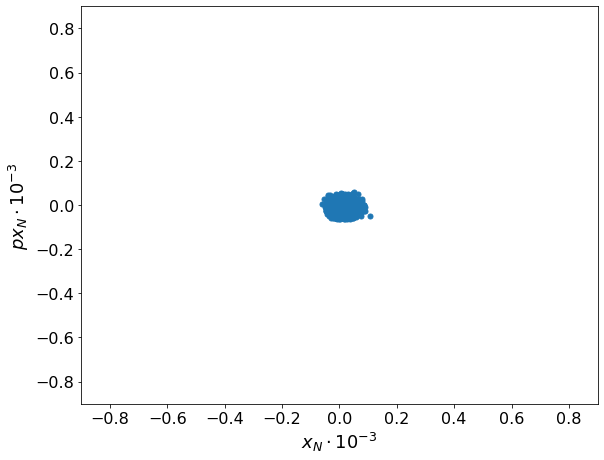

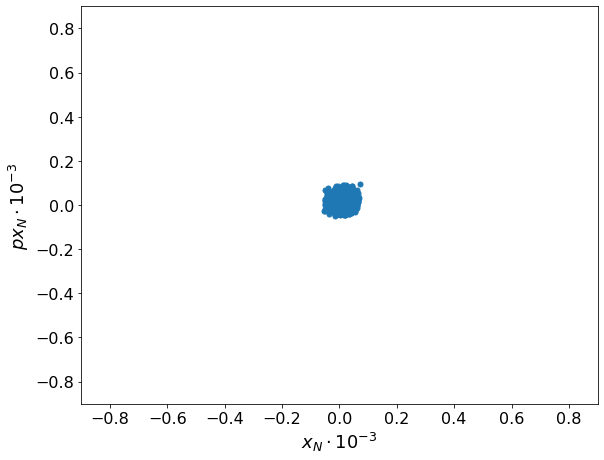

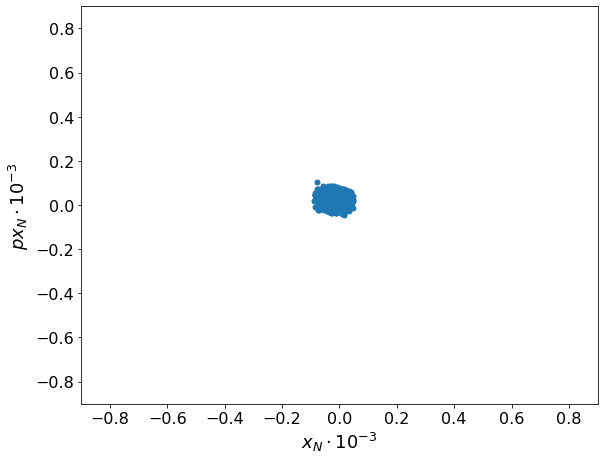

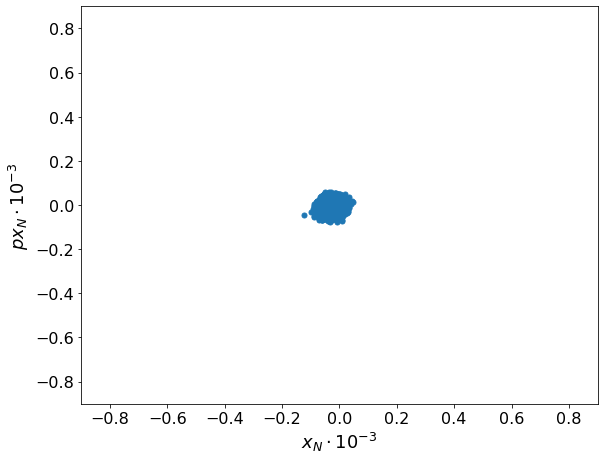

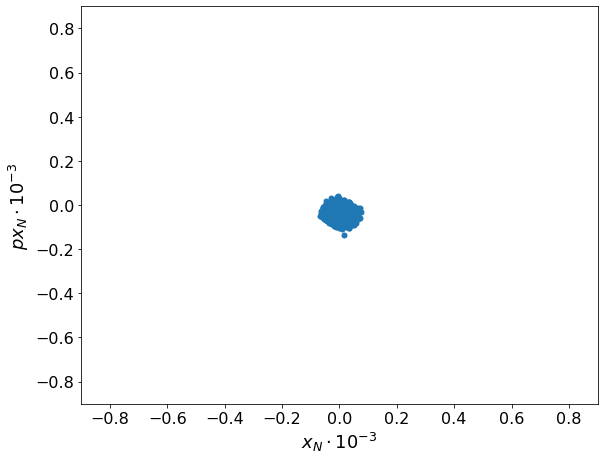

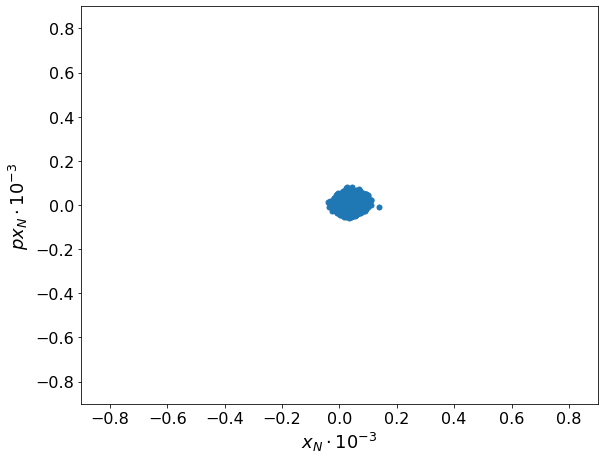

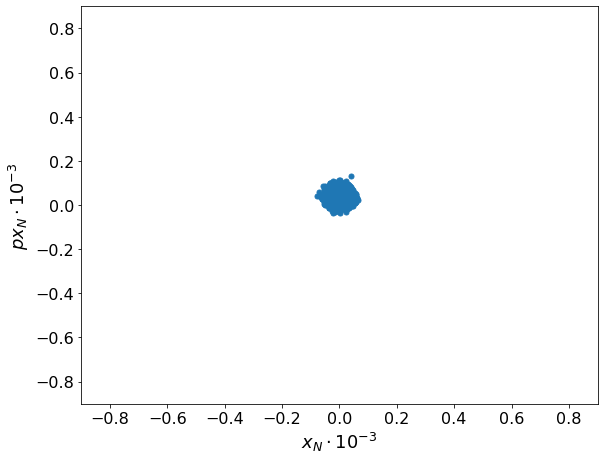

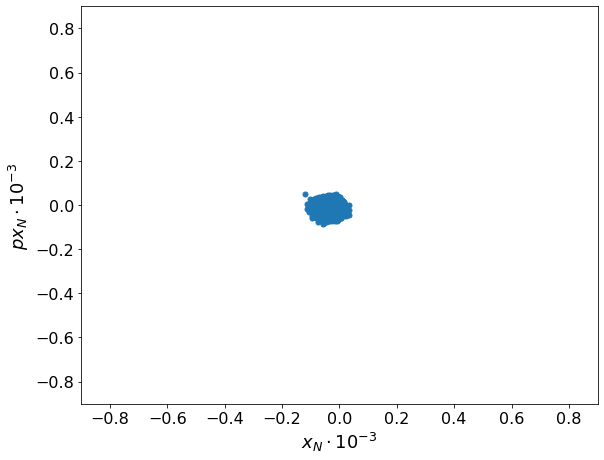

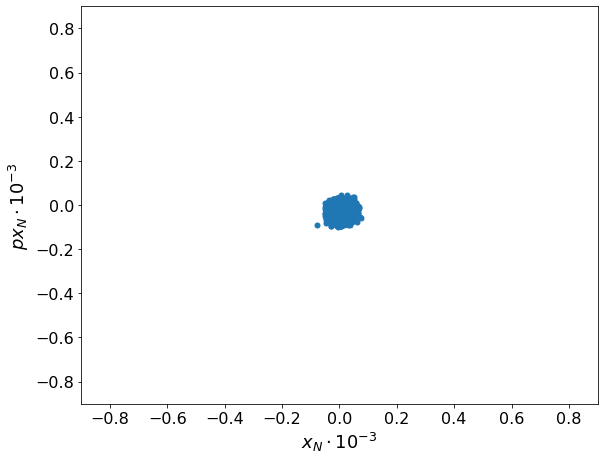

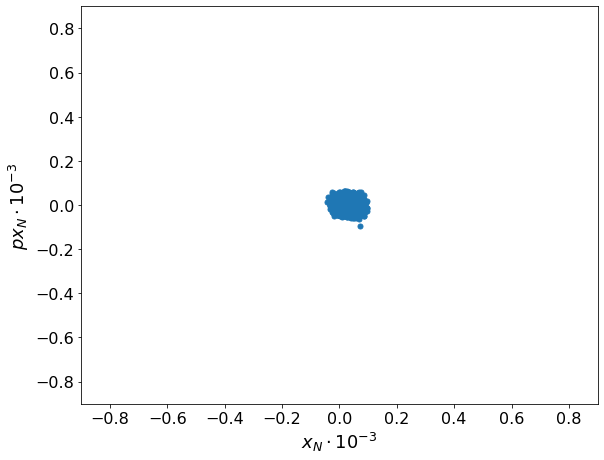

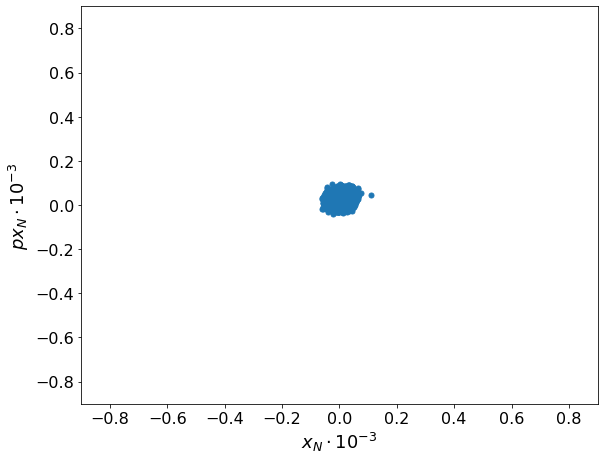

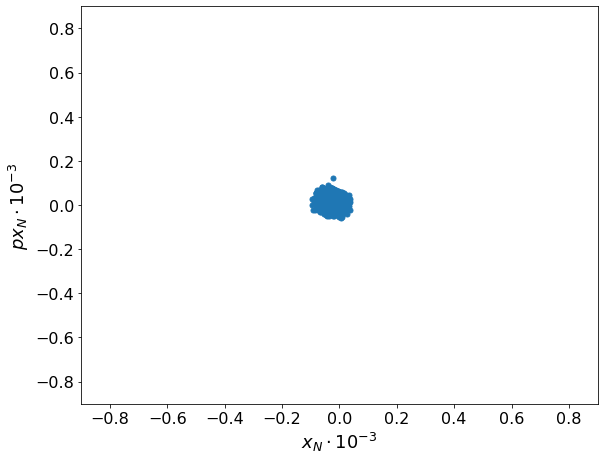

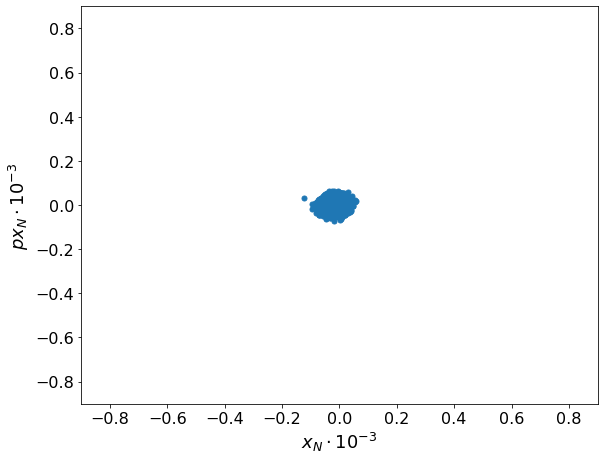

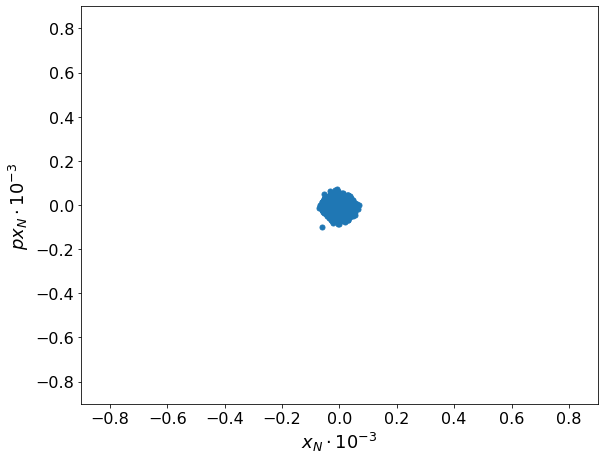

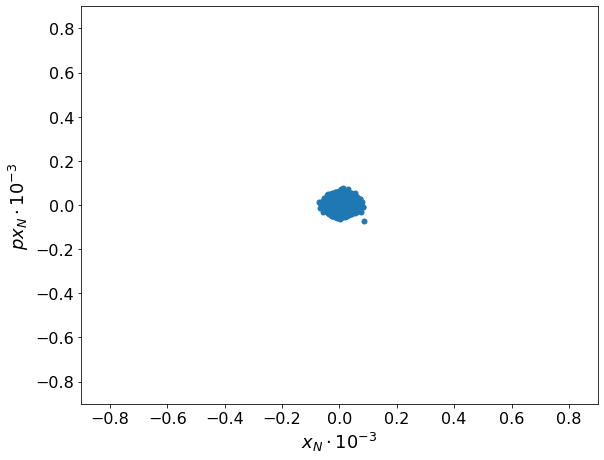

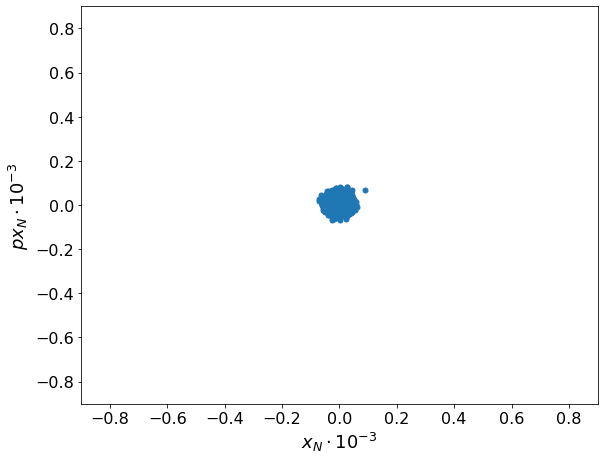

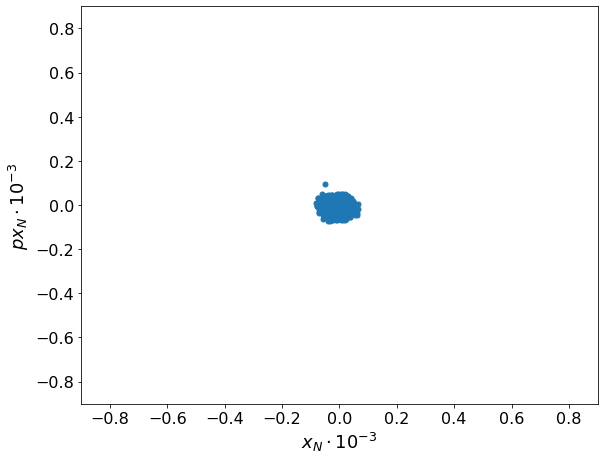

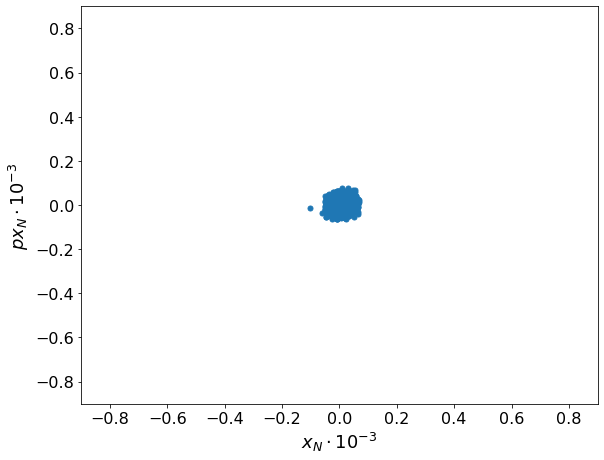

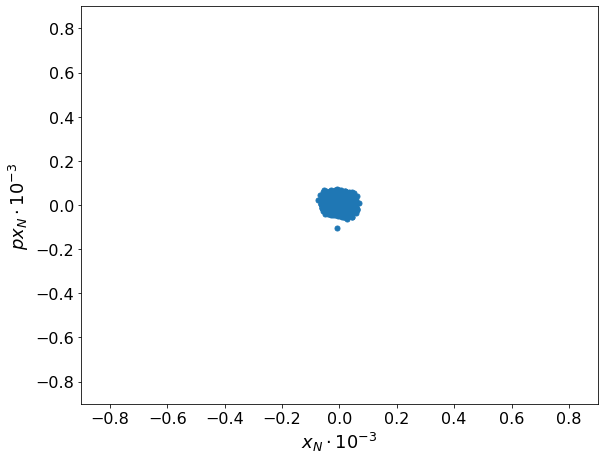

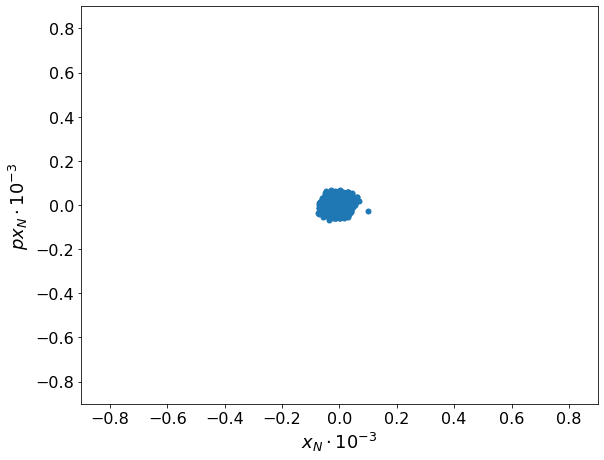

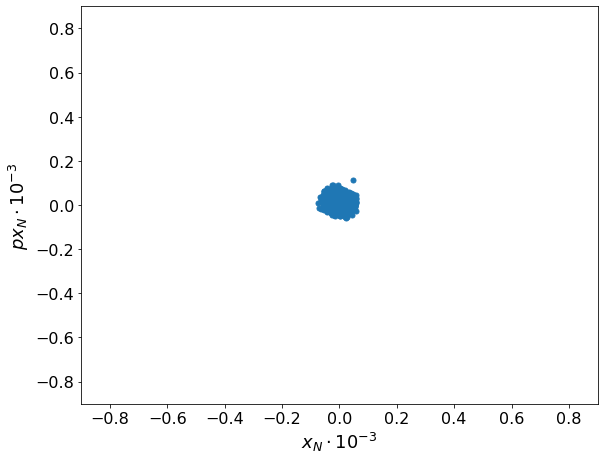

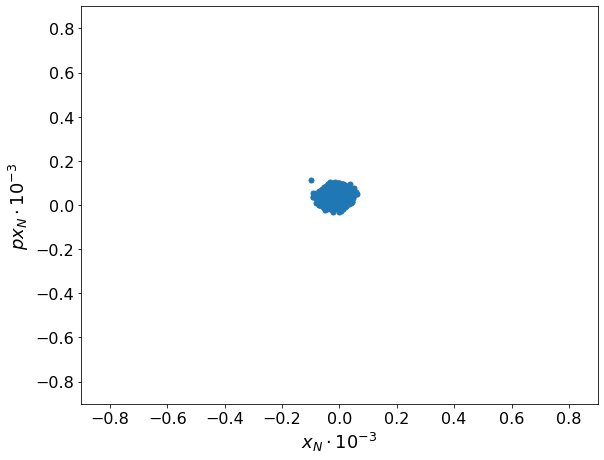

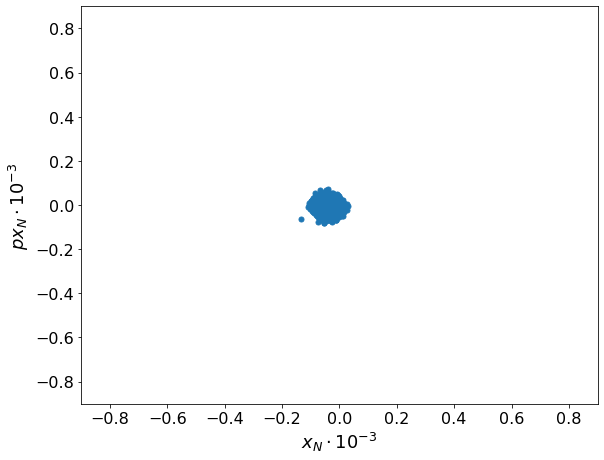

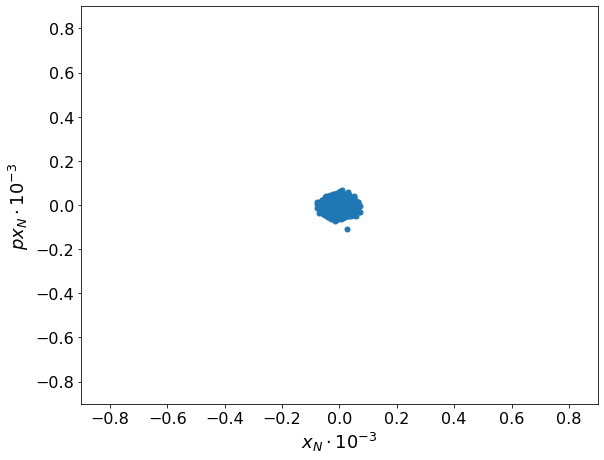

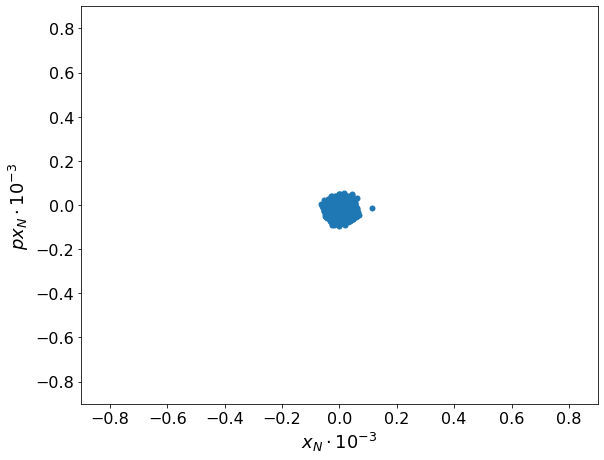

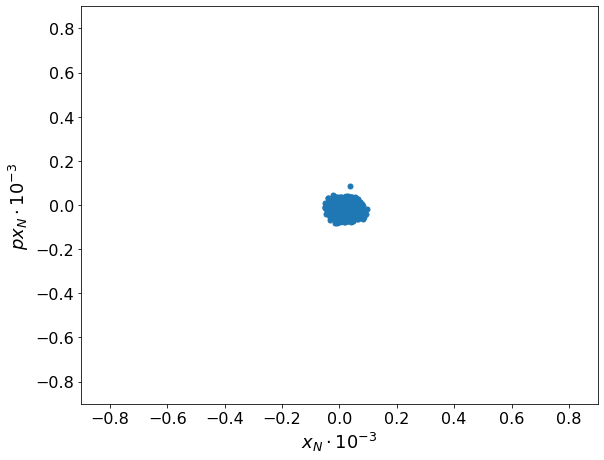

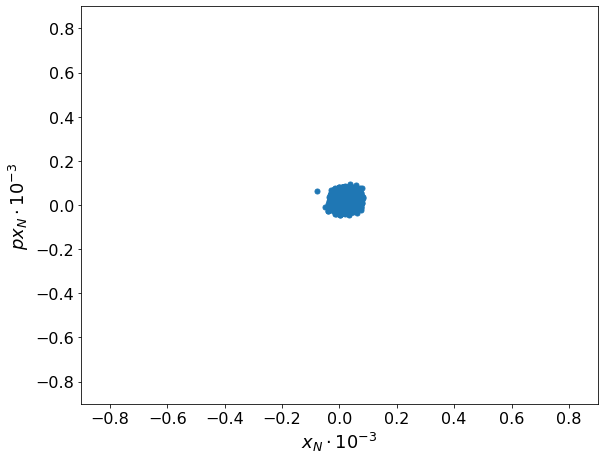

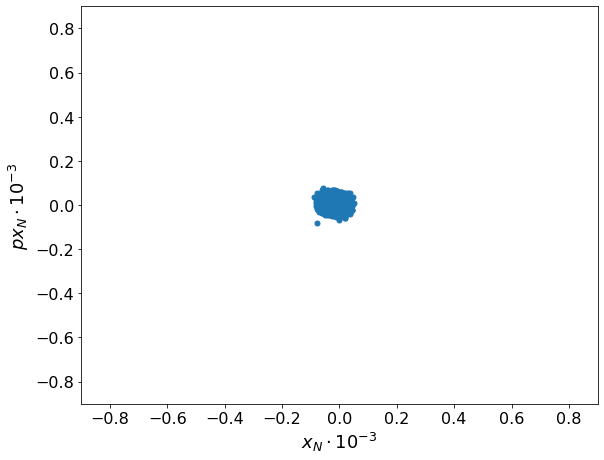

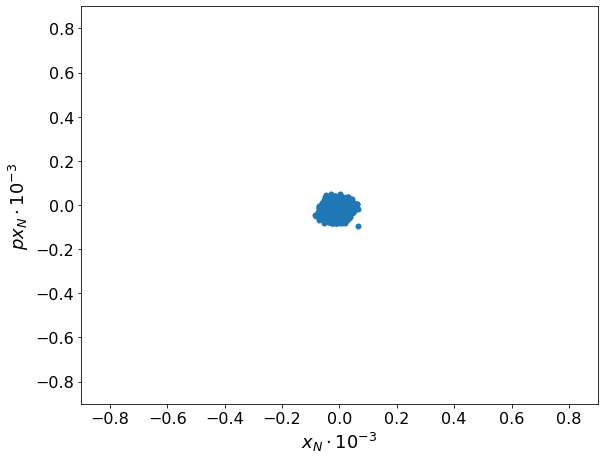

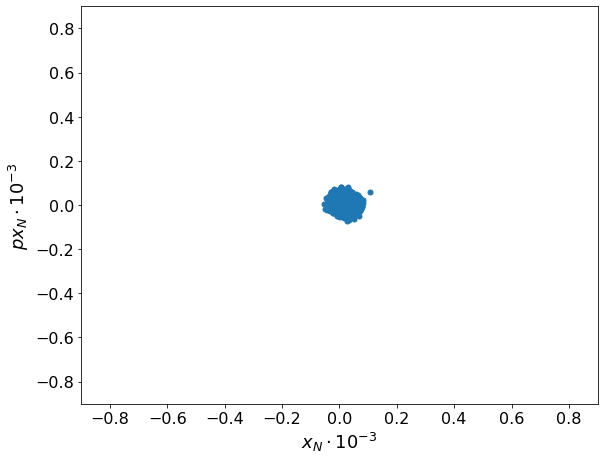

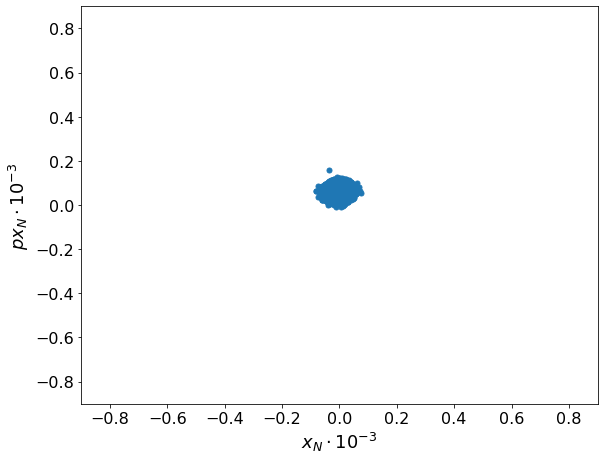

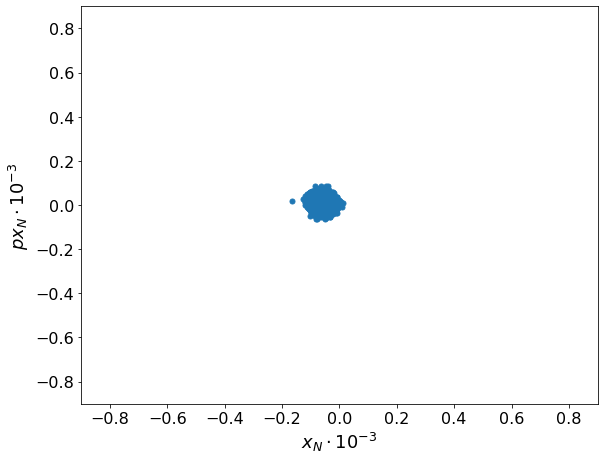

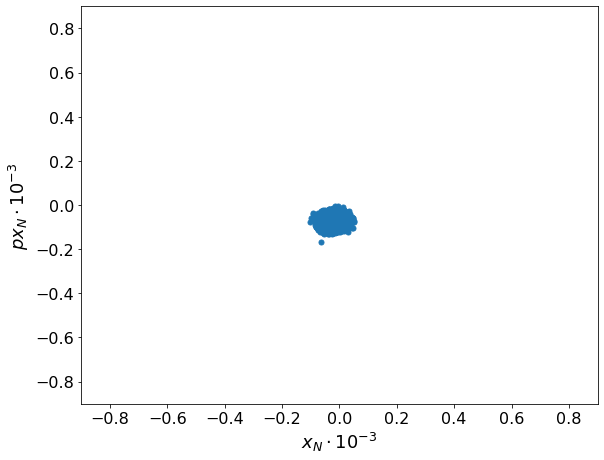

Error in callback <function flush_figures at 0x7f72e14e27b8> (for post_execute):


KeyboardInterrupt: 

In [32]:
plot_every_turn_flag = False
plot_all_together_flag = False

for turn in range(turns):
    #fig, ax = plt.subplots()
    plt.scatter(df.at[turn,'x']*1e3/sqrt(twiss.beta_x), df.at[turn,'px']*1e3*sqrt(twiss.beta_x) )
    plt.xlabel(r'$x_{N}\cdot 10^{-3}$')
    plt.ylabel(r'$px_{N}\cdot 10^{-3}$')
    plt.xlim(-0.9,0.9)
    plt.ylim(-0.9,0.9)
    plt.tight_layout()
    if plot_every_turn_flag:
        plt.savefig('./figures/phase_space_{}.png'.format(turn))
    

if plot_all_together_flag:
    plt.tight_layout()
    plt.savefig('./figures/phase_space_{}.png'.format(file_name))